In [ ]:
from dataset import *
from model import *
import warnings
warnings.filterwarnings("ignore")

In [ ]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))  # 0 corresponds to the first GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Working on device: ", device)

TRAIN_SIZE = 1200
TEST_SIZE = 10

In [ ]:
train_dataset, test_dataset = prepare_dataset(TRAIN_SIZE,TEST_SIZE,batch_size=8)
train_loader, test_loader = prepare_dataloader(train_dataset, test_dataset)

In [ ]:
# '''
# https://medium.com/analytics-vidhya/unet-implementation-in-pytorch-idiot-developer-da40d955f201
# '''

# class conv_block(torch.nn.Module):
#     def __init__(self, in_c, out_c):
#         super().__init__()
#         self.conv1 = torch.nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
#         self.bn1 = torch.nn.BatchNorm2d(out_c)        
#         self.conv2 = torch.nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
#         self.bn2 = torch.nn.BatchNorm2d(out_c)         
#         self.relu = torch.nn.ReLU()     
        
#     def forward(self, inputs):
#         x = self.conv1(inputs)
#         x = self.bn1(x)
#         x = self.relu(x)        

#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.relu(x)
#         return x
    

# class decoder_block(torch.nn.Module):
#     def __init__(self, in_c, out_c):
#         super().__init__()
#         self.up = torch.nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
#         self.conv = conv_block(out_c+out_c, out_c)     
        
#     def forward(self, inputs, skip):
#         display("shape of inputs",inputs.shape,"shape of skip",skip.shape)  
#         x = self.up(inputs)
#         # x = torch.cat([x, skip], axis=1)
#         display("Concatenation successful",x.shape)
#         x = self.conv(x)
#         return x
    

# class Unet(torch.nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.encoder = VGG_Encoder()


#         ## ----------------- v1 ----------------

#         # ## Bottleneck
#         # self.bottleneck = conv_block(512, 1024)
        
#         # """ Decoder """
#         # self.d1 = decoder_block(1024, 512)
#         # self.d2 = decoder_block(512, 256)
#         # self.d3 = decoder_block(256, 128)
#         # self.d4 = decoder_block(128, 64)

#         ## ----------------- v2 ----------------
#         # """ Decoder """
#         self.d0 = decoder_block(512, 512)
#         self.d1 = decoder_block(512, 256)
#         self.d2 = decoder_block(256, 128)
#         self.d3 = decoder_block(128, 64)
#         self.d4 = decoder_block(64, 32)


#         ## output should be 3 channels image
#         self.out = torch.nn.Conv2d(64, 3, kernel_size=1, padding=0)

#     def forward(self,x):
#         ## Encoder
#         out1, out2, out3, out4 = self.encoder(x)

#         # x = self.d0(x, out4)
#         # x = self.d1(x, out3)
#         # x = self.d2(x, out2)
#         # x = self.d3(x, out1)
#         # x = self.d4(x, x)

#         x = self.d0(out4, out4)
#         x = self.d1(x, out3)
#         x = self.d2(x, out2)
#         x = self.d3(x, out1)
#         x = self.d4(x, out1)

#         return self.out(x)
    
#     # def forward(self, x):
#     #     ## Encoder
#     #     out1, out2, out3, out4 = self.encoder(x)

#     #     ## bottleneck
#     #     out = self.bottleneck(out4)

#     #     ## decoder
#     #     d1 = self.d1(out, out4)
#     #     d2 = self.d2(d1, out3)
#     #     d3 = self.d3(d2, out2)
#     #     d4 = self.d4(d3, out1)
                
        
#     #     out = self.out(d4)
#     #     return out

In [ ]:
# model = Unet().to(device)
# model.train()

# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# criterion = torch.nn.MSELoss()

# NUM_EPOCHS = 2

# for epoch in range(NUM_EPOCHS):
#     model.train()
#     running_loss = 0.0

#     for batch in tqdm(train_loader):
         
#         grayscale_X = batch['grayscale_image']
#         X = grayscale_X.repeat(1,3,1,1).to(device)
#         y = batch['image'].to(device)

#         out = model(X)
#         loss = criterion(out, y)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item() * x.size(0)
        
#     epoch_loss = running_loss / len(train_loader)
#     print(f"Epoch {epoch+1} loss: {epoch_loss:.4f}")

-------------------------------------------------------------

In [ ]:
model = Unet().to(device)
model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.MSELoss()

NUM_EPOCHS = 15

'''
Network takes as input a 3-channel lab image and outputs a 2-channel ab image
'''
for epoch in tqdm(range(NUM_EPOCHS)):
    model.train()
    running_loss = 0.0

    for batch in train_loader:
         
        X = batch['grayscale_image'].to(device)
        y = batch['image'][:,1:,:,:].to(device) ## take only the ab channels

        out = model(X)
        loss = criterion(out, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)
        
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1} loss: {epoch_loss:.4f}")

In [ ]:
torch.save(model.state_dict(), 'unet-1200-15.pth')

In [27]:
def plot_both(image1,image2):
    # Create subplots
    plt.figure(figsize=(10, 5))

    # Plot first image
    plt.subplot(1, 2, 1)
    plt.imshow(image1)
    plt.title('Image 1')

    # Plot second image
    plt.subplot(1, 2, 2)
    plt.imshow(image2)
    plt.title('Image 2')

    plt.show()


def compose_output(original_image, predicted_ab):
    '''
    original image is in lab format
    predicte_ab are the predicted a b channels
    transfers the l channelfrom original to the predicted ab
    '''
    print(original_image.shape)
    print(predicted_ab.shape)
    l = original_image[0,:,:]
    print("L shape",l.shape)
    return torch.cat((l.unsqueeze(0),predicted_ab),0)

def visualize(image,model):
    '''
    image is in lab format
    '''
    rgb_image_input = transform_inverse(image)
    output = model(image.unsqueeze(0).to(device))
    output = output.detach().cpu()
    output = compose_output(image,output[0])
    rgb_output = transform_inverse(output)

    plot_both(rgb_image_input.permute(1,2,0).numpy(),rgb_output.permute(1,2,0).numpy())

torch.Size([3, 256, 256])
torch.Size([2, 256, 256])
L shape torch.Size([256, 256])


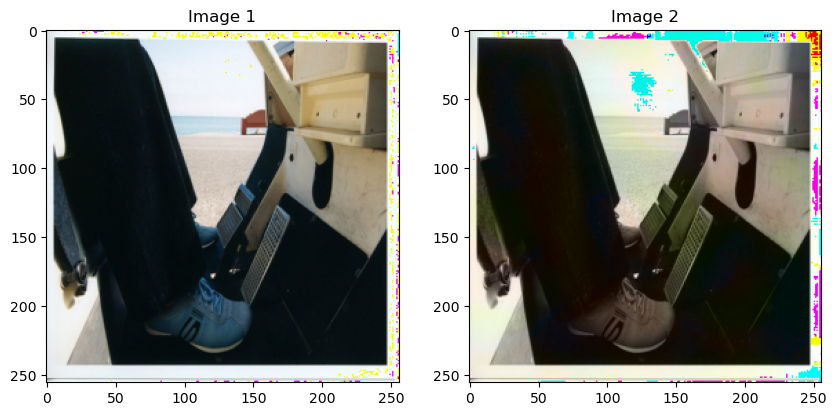

In [29]:
visualize(list(train_dataset)[17]['image'],model)

In [ ]:
visualize(list(train_dataset)[27]['image'],model)

In [ ]:
visualize(list(train_dataset)[8]['image'],model)